In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

import time
import math
import random
from tqdm import tqdm
import regex as re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Load in Always Pattern, Manual Review, and Sample DF

In [3]:
always_patterns = pd.read_csv("Storage/Data/always_patterns.csv") 
always_patterns = always_patterns[['Unnamed: 0', 'patient_id', 'sequence','original', 'label']]
always_patterns.columns = ['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']
always_patterns.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label
0,0,Z15564314,s other free text-see phs viewer social histor...,s other free text-see phs viewer Social Histor...,1
1,1,Z10171706,------- fusion: no sleep disturbance: no socia...,------- fusion: No Sleep disturbance: No Socia...,1
2,2,Z8935348,ain spasm). 30 tablet 0 unknown (outside pharm...,ain/spasm). 30 tablet 0 Unknown (outside pharm...,1
3,3,Z12212893,------- on 112mcg dose. maria will check dose ...,------- on 112mcg dose. Maria will check dos...,2
4,4,Z9598376,------- (vibramycin) 100 mg capsule take 1 cap...,------- (VIBRAMYCIN) 100 MG capsule Take 1 ca...,1


In [4]:
manual_review = pd.read_csv("Storage/Data/manual_review.csv")
manual_review = manual_review[['Unnamed: 0', 'patient_id', 'sequence','original', 'label']]
manual_review.columns = ['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']
manual_review.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label
0,75,Z10504958,ndings: general: no apparent distress. surgica...,ndings: General: No apparent distress. Surgica...,0
1,77,Z6411816,"edness, no syncope, no dyspnea endocrine no po...","edness, No Syncope, No Dyspnea Endocrine No Po...",2
2,87,Z6813204,5 reps calibrated hand gripper with silver spr...,5 reps Calibrated hand gripper with silver sp...,0
3,95,Z10492528,nancial management services: none healthcare p...,nancial management Services: none Healthcare p...,0
4,106,Z7656517,2 | 1 time: 1 | 0 time: 0) 3. “are there any r...,2 | 1 time: 1 | 0 time: 0) 3. “Are there any r...,0


In [114]:
sample = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\BigDataSets\Sampling\sample_8_12.csv") 
        # pd.read_csv("Storage/Data/20K_sample.csv")
sample = sample[["PatientID", "regex_sent"]]
sample.columns = ['patient_id', 'sequence']
sample.head()

,patient_id,sequence
0,Z6352398,"""\""ession alone in the meta-analysis. We discu..."
1,Z6353136,"""\"" ------- l obstruction ASSOCIATED DIAGNOSES..."
2,Z6353461,"""\"" ------- (156 lb) 09/19/17 71.4 kg (157 lb..."
3,Z6353764,"""\""ut answer. Optho notes from recent outpatie..."
4,Z6354111,"""\""hat would be more consistent. Has been aler..."


In [113]:
# real_world_sample = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Analysis\real_world_sample.csv")
# real_world_sample.head()

## Preprocessing for Sample DF

In [115]:
def clean_sequence(seq):
    #getting rid of special characters
    specials = '/' #etc
    seq_no_special_chars = seq.translate(str.maketrans(specials, ' '*len(specials)))
    
    #having only 1 space between words
    n = 1
    seq_no_spaces = (' '*n).join(seq_no_special_chars.split())
    
    return seq_no_spaces.lower()

In [116]:
for i in tqdm(range(len(sample))):
    sample.loc[i, "sequence"] = clean_sequence(sample.loc[i]["sequence"][3:len(sample.loc[i]["sequence"]) - 3])

100%|████████████████████████████████████████████████████████████████████████| 186730/186730 [01:01<00:00, 3020.19it/s]


## Splitting into Train, Validation, Split

This code only needs to be run once as train_test_split does a different split every time. After first run, use saved CSVs.

In [ ]:
X = always_patterns[["patient_id", "sequence"]]
y = always_patterns["annotator_label"]

y_label = y.to_numpy()
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X,y,random_state=0,test_size=0.10, stratify=y_label)

y_test_valid_label = y_test_valid.to_numpy()
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, random_state=0, test_size=(0.25), stratify=y_test_valid_label)

In [ ]:
X_2 = manual_review[["patient_id", "sequence"]]
y_2 = manual_review["annotator_label"]

y_label_2 = y_2.to_numpy()
X_train_2, X_test_valid_2, y_train_2, y_test_valid_2 = train_test_split(X_2,y_2,random_state=0,test_size=0.3, stratify=y_label_2)

y_test_valid_label_2 = y_test_valid_2.to_numpy()
X_valid_2, X_test_2, y_valid_2, y_test_2 = train_test_split(X_test_valid_2, y_test_valid_2, random_state=0, test_size=(0.15/0.3), stratify=y_test_valid_label_2)

In [ ]:
X_train = X_train.append(X_train_2)
y_train = y_train.append(y_train_2)

X_test = X_test.append(X_test_2)
y_test = y_test.append(y_test_2)

X_valid = X_valid.append(X_valid_2)
y_valid = y_valid.append(y_valid_2)

In [ ]:
len(X_train), len(X_valid), len(X_test) 

### Using Saved CSVs to load in data

In [189]:
X_train = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\train_8_11.csv")
y_train = X_train["annotator_label"]
X_train = X_train["sequence"]

In [190]:
X_valid = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\valid_8_11.csv")
y_valid = X_valid["annotator_label"]
X_valid = X_valid["sequence"]

In [191]:
X_test = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\test_8_11.csv")
y_test = X_test["annotator_label"]
X_test = X_test["sequence"]

In [192]:
X_sample = sample['sequence']

In [39]:
X_real_world = real_world_sample["sequence"]

In [10]:
len(X_train), len(X_valid), len(X_test)# , len(X_sample), len(X_real_world)

(7669, 694, 293)

## TF-IDF

In [193]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english",analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')
tfidf_train= tfidf_vectorizer.fit_transform(X_train)
tfidf_valid = tfidf_vectorizer.transform(X_valid)
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_sample = tfidf_vectorizer.transform(X_sample)
#tfidf_real_world = tfidf_vectorizer.transform(X_real_world)

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_train = pd.DataFrame(tfidf_train.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_valid = pd.DataFrame(tfidf_valid.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_test = pd.DataFrame(tfidf_test.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_sample = pd.DataFrame(tfidf_sample.A, columns = tfidf_vectorizer.get_feature_names())
#tfidf_real_world = pd.DataFrame(tfidf_real_world.A, columns = tfidf_vectorizer.get_feature_names())

tfidf_sample.head()

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zurek,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
tfidf_train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\tfidf_train_8_12.csv", index = False)
tfidf_valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\tfidf_valid_8_12.csv", index = False)
tfidf_test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\tfidf_test_8_12.csv", index = False)

In [42]:
tfidf_real_world.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\tfidf_real_sample.csv", index = False)

In [43]:
# tfidf_sample.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\BigDataSets\tfidf_sample_8_12.csv", index = False)

In [194]:
tfidf_train.shape, tfidf_valid.shape, tfidf_test.shape, tfidf_sample.shape

((7669, 24098), (694, 24098), (293, 24098), (186730, 24098))

In [18]:
y_train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\y_train_8_12.csv", index = False)
y_valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\y_valid_8_12.csv", index = False)
y_test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\y_test_8_12.csv", index = False)

## Feature Selection

### Identifying features with high correaltion using Pearson Correlation Coefficient

In [248]:
def convert_to_binary(y):
    for i in range(len(y)):
        if (y[i] == 2):
            # convert yes from 2 to 1
            y[i] = 1
        elif (y[i] == 1 or y[i] == 0):
            # convert no/ntr from 0/1 to 0
            y[i] = 0
    return y
y_train = convert_to_binary(y_train)
y_valid = convert_to_binary(y_valid)
y_test = convert_to_binary(y_test)

In [249]:
tfidf_train_features_df = pd.concat([tfidf_train, y_train.reset_index(drop=True)], axis = 1)
tfidf_test_features_df = pd.concat([tfidf_test, y_test.reset_index(drop = True)], axis = 1)
tfidf_valid_features_df = pd.concat([tfidf_valid, y_valid.reset_index(drop = True)], axis = 1)

In [250]:
def filter_features_by_cor(df):
    m = len(df.columns)
    output = df.iloc[:,m-1] 
    output_list = output.tolist()
    corrcoef_array = []

    for i in range(0,m-2):
        input_list = df.iloc[:,i].tolist()
        cols = [input_list, output_list]
        corrcoef = abs(np.corrcoef(cols)) 
        corrcoef_array = np.append(corrcoef_array,corrcoef[0,1])

    feature_names = list(df)
    feature_names = feature_names[0:m-2]
    
    output_df = pd.DataFrame(feature_names, columns=['Features'])
    output_df['CorrCoef'] = corrcoef_array
    output_df = output_df.sort_values('CorrCoef')
    output_df = output_df.reset_index()
    output_df = output_df.drop(columns = "index")
    
    return output_df

In [251]:
tfidf_output_df = filter_features_by_cor(tfidf_train_features_df)
tfidf_output_df = tfidf_output_df.sort_values(by=['CorrCoef'],ascending = False)

In [252]:
tfidf_output_df.head(10)

,Features,CorrCoef
24096,alzheimer,0.351659
24095,deficits,0.341431
24094,cognitive,0.325875
24093,moca,0.321266
24092,short,0.316328
24091,family,0.311330
24090,mother,0.294885
24089,history,0.294125
24088,father,0.286236
24087,memory,0.276754


In [253]:
tfidf_output_df.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Performance\feature_correlation_binary_labels_8_12.csv", index = False)

In [254]:
tfidf_train_features_df.drop(columns = 'annotator_label')
tfidf_test_features_df.drop(columns = 'annotator_label')
tfidf_valid_features_df.drop(columns = 'annotator_label')

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zurek,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,0.119656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Regularized Logistic Regression

In [19]:
def filter_by_corr(corr, tfidf_output_df):
    # Setting Correlation threshold
    top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
    filtered_tfidf_train = tfidf_train_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_valid = tfidf_valid_features_df.filter(items=top_tfidf_features_df['Features'])
    
    return top_tfidf_features_df, filtered_tfidf_train, filtered_tfidf_test, filtered_tfidf_valid

In [107]:
def logisitic_regression(X_train, y_train, X_test, y_test, c, want_report, want_conf_mat, save_model, name):
    # fitting model
    lr = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = c, random_state = 0, class_weight = 'balanced')
    lr.fit(X_train, y_train)
    
    # predictions
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)

    # collecting results
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob, multi_class = 'ovr', average = 'weighted')
    # print("ACC: ", acc, "AUC: ", auc)
    
    if (save_model == True):
        pickle.dump(lr, open("Storage/Model/" + name, 'wb'))
    
    if (want_report == True):
        target_names = ['Negative', 'Neither', 'Positive']
        results_lgr = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
        results_lgr = pd.DataFrame(results_lgr).transpose()
        print("Micro F1: ", metrics.f1_score(y_test, y_pred, average = "micro"))
        print("Macro F1: ", metrics.f1_score(y_test, y_pred, average = "macro"))
        print("Weighted F1: ", metrics.f1_score(y_test, y_pred, average = "weighted"))
        
        if (want_conf_mat == True):
            return lr, acc, auc, c, results_lgr, confusion_matrix(y_test, y_pred)
    
        return lr, acc, auc, c, results_lgr
    
    if (want_conf_mat == True):
        return lr, acc, auc, c, confusion_matrix(y_test, y_pred)
        
    return lr, acc, auc, c

In [35]:
def cross_validation_split(dataset, n_folds):
    # ensuring straftification across label
    yes = cross_validation[cross_validation["annotator_label"] == 1].reset_index(drop = True)
    no = cross_validation[cross_validation["annotator_label"] == 0].reset_index(drop = True)
    #ntr = cross_validation[cross_validation["annotator_label"] == 1].reset_index(drop = True)
    #print(len(yes), len(no), len(ntr))
    
    yes_count = len(yes) // n_folds
    no_count = len(no) // n_folds
    #ntr_count = len(ntr) // n_folds
    #print(yes_count, no_count, ntr_count)
    split = list()
    fold_size = len(cross_validation) // n_folds

    # shuffling data to avoid having to generate random nums through while loop
    yes = yes.sample(frac=1).reset_index(drop=True)
    no = no.sample(frac=1).reset_index(drop=True)
    #ntr = ntr.sample(frac=1).reset_index(drop=True)
    
    # creating folds
    for i in tqdm(range(n_folds)):
        fold = pd.DataFrame(columns = cross_validation.columns)

        fold = fold.append(yes[yes_count * i : (yes_count * i) + yes_count])
        #print(len(fold), "YES", )
        fold = fold.append(no[no_count * i : (no_count * i) + no_count])
        #print(len(fold), "NO", )
        #fold = fold.append(ntr[ntr_count * i : (ntr_count * i) + ntr_count])
        #print(len(fold), "NTR", ((ntr_count * i) + ntr_count) - (ntr_count * i))
        split.append(fold)
        
    return split

In [36]:
def evaluate_algorithm(dataset, n_folds):
    splits = cross_validation_split(dataset, n_folds)
    
    counter = 0
    tfidf_all_df = pd.DataFrame()
    df_list  = []
    
    for fold in splits:
        train = splits.copy()
        del train[counter]
        train = pd.concat(train)
        
        y_train = train["annotator_label"].reset_index(drop = True)
        y_train = y_train.astype(int)
        
        y_test = fold["annotator_label"].reset_index(drop = True)
        y_test = y_test.astype(int)

        train = train.drop(columns = ["annotator_label"])
        fold = fold.drop(columns = ["annotator_label"])
        
        test = list()
        corr_list = list(np.arange(1,30) * 0.01)
       
        for corr in corr_list:
            acc_list = []
            auc_list = []
            c_list = []
             
            # filtering by correlation coefficient
            top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
            filtered_tfidf_train = train.filter(items=top_tfidf_features_df['Features'])
            filtered_tfidf_fold = fold.filter(items=top_tfidf_features_df['Features'])
            filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
            
            #print(filtered_tfidf_train.shape)
            #print(filtered_tfidf_fold.shape)
            
            # tuning for optimal lambda value
            for c in [0.01, 0.1, 1, 10, 100]:
                #name = "Fold-" + str((counter + 1)) + "-Corr-" + str(corr) + "-C-" + str(c) + ".sav"
                lr, acc, auc, c = logisitic_regression(filtered_tfidf_train, y_train, filtered_tfidf_fold, y_test, c, False, False, False, "")
                acc_list.append(acc)
                auc_list.append(auc)
                c_list.append(c)
            
            # gathering model stats
            acc_df = pd.DataFrame(acc_list, columns=['acc'])
            auc_df = pd.DataFrame(auc_list, columns=['auc'])
            c_df = pd.DataFrame(c_list, columns=['c_value'])
            
            assert len(acc_df) == len(auc_df) == len(c_df)
            
            #acc_df["fold_number"] = auc_df["fold_number"] = c_df["fold_number"] = [counter] * len(auc_df)
            
            iter_df = pd.concat([c_df, acc_df, auc_df], axis=1)
            iter_df['corr_thres'] = [corr] * len(iter_df)
            iter_df['fold_number'] = [(counter + 1)] * len(iter_df)
            df_list.append(iter_df)
            
        print("Completed Fold #: ", counter + 1)
        counter += 1
        
        print("Stats DF has", len(df_list), "records")
        
        #df_list.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Optimizing-data\sample_stat_df.csv", index = False)
    return df_list

In [37]:
cross_validation = pd.concat([tfidf_train_features_df, tfidf_valid_features_df])
tfidf_all_df = evaluate_algorithm(cross_validation, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Completed Fold #:  1
Stats DF has 29 records
Completed Fold #:  2
Stats DF has 58 records
Completed Fold #:  3
Stats DF has 87 records
Completed Fold #:  4
Stats DF has 116 records
Completed Fold #:  5
Stats DF has 145 records
Completed Fold #:  6
Stats DF has 174 records
Completed Fold #:  7
Stats DF has 203 records
Completed Fold #:  8
Stats DF has 232 records
Completed Fold #:  9
Stats DF has 261 records
Completed Fold #:  10
Stats DF has 290 records


In [38]:
tfidf_all_df = pd.concat(tfidf_all_df)

In [39]:
corr_list = list(np.arange(1,30) * 0.01)
average_results_df = []

for corr in corr_list:
    for c in [0.01, 0.1, 1, 10, 100]:
        filtered = tfidf_all_df[(tfidf_all_df["corr_thres"] == corr) & (tfidf_all_df["c_value"] == c)]
        avg_auc = filtered["auc"].mean()
        avg_acc = filtered["acc"].mean()

        filler = np.arange(5, 9)**2
        df = pd.DataFrame(filler.reshape(1, 4), columns = ["c_value", "acc", "auc", "corr_thres"])
        df.loc[df.index] = [c, avg_acc, avg_auc, corr]
        #print(df)
        
        average_results_df.append(df)

In [40]:
average_results_df = pd.concat(average_results_df)

In [41]:
average_results_df[average_results_df['auc'] == max(average_results_df['auc'])]

,c_value,acc,auc,corr_thres
0,10.0,0.971616,0.994738,0.01


In [108]:
# Specific parameter setting performance
corr = 0.01
c = 10

y_train_cross_valid = cross_validation["annotator_label"]
y_test_cross_valid = tfidf_test_features_df["annotator_label"]

cross_validation.drop(columns = ["annotator_label"])
tfidf_test_features_df.drop(columns = ["annotator_label"])

# Setting Correlation threshold
top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
filtered_tfidf_train = cross_validation.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])

# Running model
lr, acc_optimized, auc_optimized, c_list, report, conf_mat = logisitic_regression(filtered_tfidf_train, y_train_cross_valid, filtered_tfidf_test, y_test_cross_valid, c, True, True, False, "")

print("\nC: ", c, "\n", report)
print("\nAUC: ", auc_optimized)
print("ACC: ", acc_optimized)
print("\nConfusion Matrix: \n", conf_mat)

Micro F1:  0.8395904436860068
Macro F1:  0.8139247980627292
Weighted F1:  0.8425507347385657

C:  10 
               precision    recall  f1-score    support
Negative       0.838384  0.798077  0.817734  104.00000
Neither        0.925373  0.879433  0.901818  141.00000
Positive       0.650000  0.812500  0.722222   48.00000
accuracy       0.839590  0.839590  0.839590    0.83959
macro avg      0.804586  0.830003  0.813925  293.00000
weighted avg   0.849384  0.839590  0.842551  293.00000

AUC:  0.9454993869092255
ACC:  0.8395904436860068

Confusion Matrix: 
 [[ 83   7  14]
 [ 10 124   7]
 [  6   3  39]]


In [74]:
filtered_tfidf_test["label"] = y_test_cross_valid

In [76]:
y_test_neither = filtered_tfidf_test[filtered_tfidf_test["label"] == 1]
y_test_no = filtered_tfidf_test[filtered_tfidf_test["label"] == 0]
y_test_yes = filtered_tfidf_test[filtered_tfidf_test["label"] == 2]

In [88]:
filtered_tfidf_test = filtered_tfidf_test.drop(columns = ["label"])

In [83]:
neither_yes = pd.concat([y_test_neither, y_test_yes], axis = 0)
neither_yes = neither_yes.drop(columns = ["label"])

In [84]:
neither_yes

,intact,oriented,concentration,orientation,perceptions,sensorium,judgment,fund,experiences,ideation,...,frail,request,ho,1959,meat,cites,rested,betadine,actuation,sirolimus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
preds = lr.predict(neither_yes)
#precision_score()

In [ ]:
"""   
      NO   NTR YES
NO  [[439  9  21]
NTR [  5 457   7]
YES [ 26  19 424]]

NO - 439/469 TP, 9/469 NTR when should be NO, and 21/469 YES when should be NO
    Precision: 439/(439+5+26)
    Recall: 439/(439+21+9)
    fl: (439*2)/(470+469)

NTR - 457/469 TP, 5/469 NO when should be NTR, and 7/469 YES when should be NTR
YES - 424/469 TP, 19/469 NTR when should be YES, and 26/469 are NO when should be YES
"""

In [ ]:
"""   
      NO   NTR YES
NO  [[83  7  14]
NTR  [10 124  7]
YES  [6  3   39]]

no
tpr: 0.8

"""

In [240]:
FP = conf_mat.sum(axis = 0) - np.diag(conf_mat) 
FN = conf_mat.sum(axis = 1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)
print("FPR: ", FPR)

Sensitivity:  [0.79807692 0.87943262 0.8125    ]
Specificity:  [0.91534392 0.93421053 0.91428571]
NPV:  [0.89175258 0.89308176 0.96137339]
PPV:  [0.83838384 0.92537313 0.65      ]
FPR:  [0.08465608 0.06578947 0.08571429]


## Saving 

In [ ]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
train = pd.concat([X_train, y_train], axis = 1)

In [ ]:
X_valid = X_valid.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
valid = pd.concat([X_valid, y_valid], axis = 1)

In [ ]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
test = pd.concat([X_test, y_test], axis = 1)

In [ ]:
train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\train_8_11.csv", index = False)
valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\valid_8_11.csv", index = False)
test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\test_8_11.csv", index = False)

In [104]:
pickle.dump(lr, open("Storage/" + "model_8_30.sav", 'wb'))

## Model Predictions

In [195]:
tfidf_output_df = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Performance\feature_correlation_multiclass_labels_8_12.csv")

In [196]:
top_tfidf_features_df_sample = tfidf_output_df[tfidf_output_df['CorrCoef'] > 0.01]

In [200]:
model = pickle.load(open(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\model_8_30.sav", 'rb'))

### Getting Train and Test Set Predictions and  Probabilties

In [39]:
#train = pd.read_csv(r"C:\Users\tanis\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\data\train_8_11.csv")
#valid = pd.read_csv(r"C:\Users\tanis\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\data\valid_8_11.csv")
#cross_validation_df = pd.concat([train, valid])

test = pd.read_csv(r"C:\Users\tanis\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\data\test_8_11.csv")

In [60]:
test_predictions = model.predict(tfidf_test.filter(items = top_tfidf_features_df_sample['Features']))
#cross_valid_predictions = model.predict(cross_validation.filter(items = top_tfidf_features_df_sample['Features']))

In [65]:
#cross_validation_df["predictions"] = cross_valid_predictions
test["predictions"] = test_predictions

In [66]:
test_proba = model.predict_proba(tfidf_test.filter(items = top_tfidf_features_df_sample['Features']))
#cross_valid_proba = model.predict_proba(cross_validation.filter(items = top_tfidf_features_df_sample['Features']))

In [68]:
test_proba = test_proba[:, 1]

In [69]:
test["probability"] = test_proba

In [43]:
# test_proba = np.array([[x] for x in np.max(test_proba, axis=1)])
# test_proba = [item for sublist in test_proba for item in sublist]
# test["probability"] = test_proba

# cross_valid_proba = np.array([[x] for x in np.max(cross_valid_proba, axis=1)])
# cross_valid_proba = [item for sublist in cross_valid_proba for item in sublist]
# cross_validation_df["probability"] = cross_valid_proba

In [46]:
def convert_to_binary(y):
    for i in range(len(y)):
        if (y[i] == 2):
            # convert yes from 2 to 1
            y[i] = 1
        elif (y[i] == 1 or y[i] == 0):
            # convert no/ntr from 0/1 to 0
            y[i] = 0
    return y

test["annotator_label"] = convert_to_binary(test["annotator_label"])

In [73]:
#cross_validation_df.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Baseline_Model\data\train_full.csv", index = False)
test.to_csv(r"C:\Users\tanis\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Baseline_Model\data\test_binary_classification.csv", index = False)

In [168]:
len(cross_validation_df["patient_id"].unique()), len(cross_validation_df), len(test)

(2417, 8363, 293)

### Running on Samples

In [203]:
sample_predictions = model.predict(tfidf_sample.filter(items = top_tfidf_features_df_sample['Features']))

In [204]:
sample["predictions"] = sample_predictions

In [205]:
sample_proba = model.predict_proba(tfidf_sample.filter(items = top_tfidf_features_df_sample['Features']))

In [206]:
sample_proba = np.array([[x] for x in np.max(sample_proba, axis=1)])
sample_proba = [item for sublist in sample_proba for item in sublist]

In [207]:
sample["probability"] = sample_proba

In [208]:
sample.head()

,patient_id,sequence,predictions,probability
0,Z6352398,ession alone in the meta-analysis. we discusse...,2,0.583588
1,Z6353136,------- l obstruction associated diagnoses sma...,2,0.986656
2,Z6353461,------- (156 lb) 09 19 17 71.4 kg (157 lb 6.4 ...,0,0.940278
3,Z6353764,ut answer. optho notes from recent outpatient ...,0,0.919579
4,Z6354111,hat would be more consistent. has been alert o...,0,0.573025


In [209]:
sample.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Predictions\sample_predictions_9_1.csv", index = False)

### Finding Optimal Patient Aggregation Scheme

In [210]:
sample["predictions"].value_counts()

0    113107
2     49046
1     24577
Name: predictions, dtype: int64

In [211]:
sample

,patient_id,sequence,predictions,probability
0,Z6352398,ession alone in the meta-analysis. we discusse...,2,0.583588
1,Z6353136,------- l obstruction associated diagnoses sma...,2,0.986656
2,Z6353461,------- (156 lb) 09 19 17 71.4 kg (157 lb 6.4 ...,0,0.940278
3,Z6353764,ut answer. optho notes from recent outpatient ...,0,0.919579
4,Z6354111,hat would be more consistent. has been alert o...,0,0.573025
...,...,...,...,...
186725,Z16320629,''she took a break' and wants to discuss with ...,2,0.913473
186726,Z16320629,"'all of her medications, including aspirin. de...",2,0.855714
186727,Z16320629,"'patient, chart, daughter olga mode of contact...",0,0.723209
186728,Z16320629,"'patient, chart, daughter olga mode of contact...",0,0.723209


In [212]:
apoe = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Baseline_Model\data\tanish_predictions_with_structured_features.csv")

In [241]:
apoe_e2 = apoe[(apoe["APOE"] == "e2/e2") | (apoe["APOE"] == "e2/e3")]
len((apoe_e2[apoe_e2["patient_CI"] == 1]))/len(apoe_e2)

0.6157354618015963

In [242]:
binary_model = pickle.load(open(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\model_8_12_binary_classification.sav", 'rb'))

In [256]:
top_tfidf_features_df_sample_binary = tfidf_output_df[tfidf_output_df['CorrCoef'] > 0.07]

In [257]:
binary_sample_predictions = binary_model.predict(tfidf_sample.filter(items = top_tfidf_features_df_sample_binary['Features']))

In [258]:
binary_sample_preds = sample.copy()
binary_sample_preds["predictions"] = binary_sample_predictions

In [259]:
binary_sample_preds["predictions"].value_counts()

0    107347
1     79383
Name: predictions, dtype: int64

In [261]:
binary_sample_preds = pd.merge(binary_sample_preds, apoe, how = "right", on = "patient_id")

In [213]:
sample_preds_cp = sample.copy()
sample_preds_cp = pd.merge(sample_preds_cp, apoe, how = "right", on = "patient_id")

In [262]:
binary_sample_preds

,patient_id,sequence,predictions,probability,patient_CI,num_sequences_patient,EMPI,Dx_Count,Med_Count,AD_Med_or_ICD_Code,APOE
0,Z6352398,ession alone in the meta-analysis. we discusse...,0,0.583588,1,2,100000272,3,0,1,e3/e3
1,Z6352398,"'ial source of info:? patient, chart mode of c...",1,0.389788,1,2,100000272,3,0,1,e3/e3
2,Z6353136,------- l obstruction associated diagnoses sma...,1,0.986656,1,9,100001150,0,0,0,e3/e3
3,Z6353136,'ory is obtained from patient and pt's dtr adr...,0,0.523441,1,9,100001150,0,0,0,e3/e3
4,Z6353136,'ed during the visit to clarify patient's medi...,0,0.883240,1,9,100001150,0,0,0,e3/e3
...,...,...,...,...,...,...,...,...,...,...,...
186725,Z15769512,'in vascular neurology clinic. please see the ...,1,0.683052,1,3,113093596,0,0,0,e3/e4
186726,Z15769512,'in vascular neurology clinic. please see the ...,1,0.658477,1,3,113093596,0,0,0,e3/e4
186727,Z15769512,'in vascular neurology clinic. please see the ...,1,0.683522,1,3,113093596,0,0,0,e3/e4
186728,Z15811708,'think i\\\\\\\\'m far away but i\\\\\\\\'m re...,1,0.989254,1,1,113149962,0,0,0,e3/e4


In [215]:
apoe["APOE"].value_counts()

e3/e3             8751
e3/e4             2862
e2/e3             1675
e2/e4 or e1/e3     302
e4/e4              272
e2/e2               79
Name: APOE, dtype: int64

In [216]:
e_2 = sample_preds_cp[(sample_preds_cp["APOE"] == "e2/e2") | (sample_preds_cp["APOE"] == "e2/e3")]
e_3 = sample_preds_cp[(sample_preds_cp["APOE"] == "e3/e3")]
e_4 = sample_preds_cp[(sample_preds_cp["APOE"] == "e4/e4") | (sample_preds_cp["APOE"] == "e2/e4 or e1/e3") | (sample_preds_cp["APOE"] == "e3/e4")]

In [217]:
len(e_2), len(e_3), len(e_4)

(23101, 114378, 49251)

In [312]:
def percent_ci(df, sequence_threshold):
    patient_level_preds = []
    p_id_ls = []
    ci_count = 0
    for p_id in df["patient_id"].unique():
        sequences = df[df["patient_id"] == p_id]
        if len(sequences[sequences["predictions"] == 2]) >= sequence_threshold:
            patient_level_preds.append(1)
            ci_count += 1
        else:
            patient_level_preds.append(0)
        p_id_ls.append(p_id)
    return patient_level_preds, ci_count/len(df["patient_id"].unique()), p_id_ls

In [316]:
x_axis = []
y_axis_e2 = []
y_axis_e3 = []
y_axis_e4 = []

for i in tqdm(range(10)):
    e_2_preds, e_2_percent, e_2_p_id = percent_ci(e_2, i+1)
    e_3_preds, e_3_percent, e_3_p_id = percent_ci(e_3, i+1)
    e_4_preds, e_4_percent, e_4_p_id = percent_ci(e_4, i+1)
    
    x_axis.append(i+1)
    y_axis_e2.append(e_2_percent)
    y_axis_e3.append(e_3_percent)
    y_axis_e4.append(e_4_percent)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:23<00:00, 140.34s/it]


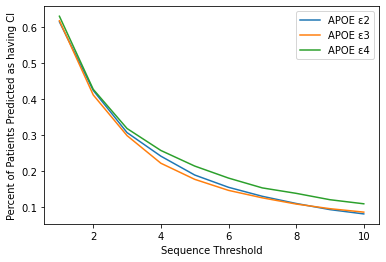

In [324]:
plt.plot(x_axis, y_axis_e2, label='APOE ε2')
plt.plot(x_axis, y_axis_e3, label='APOE ε3')
plt.plot(x_axis, y_axis_e4, label='APOE ε4')

plt.xlabel("Sequence Threshold")
plt.ylabel("Percent of Patients Predicted as having CI")
plt.legend(loc='best')
plt.show()

In [225]:
revised_preds = pd.DataFrame()
revised_preds["patient_id"] = e_2_p_id + (e_3_p_id) + (e_4_p_id)

In [227]:
revised_preds["predictions"] = e_2_preds + (e_3_preds) + (e_4_preds)

In [229]:
revised_preds["predictions"].value_counts()

0    11766
1     2175
Name: predictions, dtype: int64

In [230]:
revised_patients = pd.merge(apoe, revised_preds, how = "right", on = "patient_id")

In [235]:
revised_patients.drop(columns = ["patient_CI"])

,patient_id,num_sequences_patient,EMPI,Dx_Count,Med_Count,AD_Med_or_ICD_Code,APOE,predictions
0,Z6354527,2,100002765,0,0,0,e2/e3,0
1,Z6357384,1,100006119,0,0,0,e2/e3,0
2,Z6358782,1,100007763,0,0,0,e2/e3,0
3,Z6359488,16,100008569,19,0,1,e2/e3,0
4,Z6359758,25,100008870,0,0,0,e2/e3,0
...,...,...,...,...,...,...,...,...
13936,Z15306032,1,111523532,0,0,0,e4/e4,0
13937,Z15426107,6,112157856,8,0,1,e3/e4,1
13938,Z15538190,1,112478766,0,0,0,e3/e4,0
13939,Z15769512,3,113093596,0,0,0,e3/e4,0


In [236]:
TP = len(revised_patients[(revised_patients["predictions"] == 1) & (revised_patients["AD_Med_or_ICD_Code"] == 1)])

1051

In [167]:
print(note.loc[note['id'] == 8481]['PatientID'])

8480    Z6448542
Name: PatientID, dtype: object


In [237]:
FP = len(revised_patients[(revised_patients["predictions"] == 1) & (revised_patients["AD_Med_or_ICD_Code"] == 0)])

1124

In [238]:
TN = len(revised_patients[(revised_patients["predictions"] == 0) & (revised_patients["AD_Med_or_ICD_Code"] == 0)])

11068

In [239]:
FN = len(revised_patients[(revised_patients["predictions"] == 0) & (revised_patients["AD_Med_or_ICD_Code"] == 1)])

698

## ROC-Curve

In [327]:
pred_prob[:10]

array([[1.89786225e-04, 9.95352136e-01, 4.45807811e-03],
       [8.85389789e-04, 9.93789361e-01, 5.32524966e-03],
       [9.96982926e-01, 2.90801022e-03, 1.09063819e-04],
       [1.69947896e-03, 9.97076315e-01, 1.22420561e-03],
       [3.04765747e-02, 1.39554647e-03, 9.68127879e-01],
       [2.57131226e-03, 9.97408194e-01, 2.04940843e-05],
       [5.29203957e-16, 1.00000000e+00, 2.69861989e-11],
       [1.28158224e-12, 1.00000000e+00, 1.02179201e-10],
       [7.75006015e-08, 9.99167632e-01, 8.32290405e-04],
       [9.99160017e-01, 5.41025734e-05, 7.85880549e-04]])

In [326]:
pred_prob[:,0]

array([1.89786225e-04, 8.85389789e-04, 9.96982926e-01, 1.69947896e-03,
       3.04765747e-02, 2.57131226e-03, 5.29203957e-16, 1.28158224e-12,
       7.75006015e-08, 9.99160017e-01, 2.88465660e-03, 2.67246659e-05,
       9.99601114e-01, 6.02531087e-04, 7.06579085e-12, 9.06751700e-03,
       4.86443001e-05, 5.67806408e-01, 9.98831620e-01, 4.29145143e-01,
       5.18423443e-05, 1.97175911e-06, 9.86011739e-01, 1.76550242e-07,
       1.61485417e-05, 9.56932566e-01, 9.95230108e-01, 3.09766926e-03,
       2.04298196e-05, 4.97634542e-06, 3.27728370e-03, 1.33312495e-04,
       1.80107732e-02, 1.12010545e-03, 9.90676080e-01, 9.97494939e-01,
       1.02775497e-02, 1.60660237e-04, 8.03077557e-01, 9.98839277e-01,
       5.86554259e-03, 3.14024594e-07, 9.65509508e-03, 1.49249445e-04,
       9.99979219e-01, 9.99922202e-01, 9.82778000e-01, 9.97869399e-01,
       8.81655033e-04, 4.76892928e-07, 3.24961684e-01, 8.50648316e-01,
       1.03786960e-06, 5.62598970e-06, 1.96526254e-03, 6.00644058e-08,
      

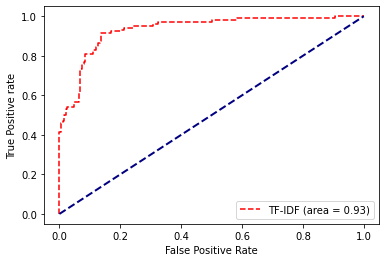

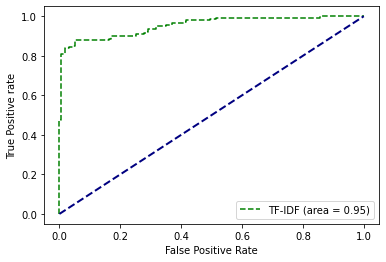

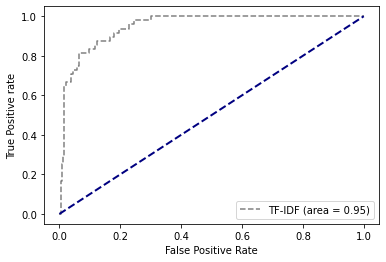

In [103]:
n_class = 3

pred_prob = lr.predict_proba(filtered_tfidf_test)

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, pred_prob[:,i], pos_label = i)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
lw = 2

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--', color='orange', label='TF-IDF (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='TF-IDF (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='TF-IDF (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

#plt.title('AUROC Curve for TF-IDF')

#plt.savefig('AUROC Curve for TF-IDF', dpi = 300)